<a href="https://colab.research.google.com/github/eversonmariano/Analise-de-Dados_Machine-learning/blob/main/DepartamentoM%C3%A9dico.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Departamento Médico

Estudo de caso: 

Detecção de uma doença baseado em imagens médicas através de técnicas de Deep Learning. Mais especificamente falando, fomos contratados por um hospital por um hospital para automatizar o processo de detectar e classificar doenças pulmonares, reduzindo o custo e tempo da detecção.



Os profissionais de saúde coletaram várias imagens de raio-x, 133 imagens que pertecem a 4 classes:

Healthy (saúdavel);

Covid-19;

Bacterial Pneumonia;

Viral Pneumonia.

Objetivo:

O objetivo deste projeto é detectar o Covid-19 a partir de raios-X e também diferenciar o Covid-19 da pneumonia viral e da pneumonia bacteriana. Criei um conjunto de dados personalizado que contém imagens de raios-x covid-19, imagens de raios-x de pneumonia viral, imagens de raios-x de pneumonia bacteriana e imagens de raios-x de pessoas normais. Cada classe contém 133 imagens.

In [1]:
import os
import cv2 #openCV
import tensorflow as tf #biblioteca da google p/ trabalhar com redes neurais
import numpy as np #recursos matemáticos
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import ResNet50 #ResNet50 é uma rede neural pré treinada muito eficiente.
from tensorflow.keras.layers import Input, Dense, AveragePooling2D, Dropout, Flatten #camadas da rede neural
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator #acessarmos um diretorios de imagem e enviarmos para uma rede neural
from tensorflow.keras.callbacks import ModelCheckpoint #salvar os pesos da rede neural
import matplotlib.pyplot as plt
import seaborn as sns #geração de gráficos

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
xray_directory = '/content/drive/MyDrive/Ciencias-de-Dados-para-Empresas/DepartamentoMedico/Dataset'

In [4]:
os.listdir(xray_directory)

['.DS_Store', '1', '2', '0', '3']

In [5]:
#Acessando as imagens
image_generator = ImageDataGenerator(rescale=1./255)

In [6]:
#Buscar as imagens de treinamento
train_generator = image_generator.flow_from_directory(batch_size= 40, directory=xray_directory,
                                                      shuffle = True, target_size=(256, 256), 
                                                      class_mode = 'categorical', subset='training')

Found 532 images belonging to 4 classes.


In [7]:
#criando variaveis para testar o treinamento

train_images, train_labels = next(train_generator)

In [8]:
#verificar as especificaçoes das primeiras 40 imagens 
train_images.shape

(40, 256, 256, 3)

In [9]:
#Mostrar as classes p/ cada uma das imagens
train_labels

array([[0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.]],

In [10]:
#As classes serao representadas por 4 neuronios
#Covid1_19 - 1 0 0 0
#Normal    - 0 1 0 0
#Viral     - 0 0 1 0
#Bacterial - 0 0 0 1 
label_names = {0: 'Convid-19', 1: 'Normal', 2: 'Pneumonia viral', 3: 'Pneumonia bacterial'}

##Visualização dos dados

In [11]:
np.arange(0,36)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35])

In [12]:
np.argmax(train_labels[0])

3

In [13]:
label_names[1]

'Normal'

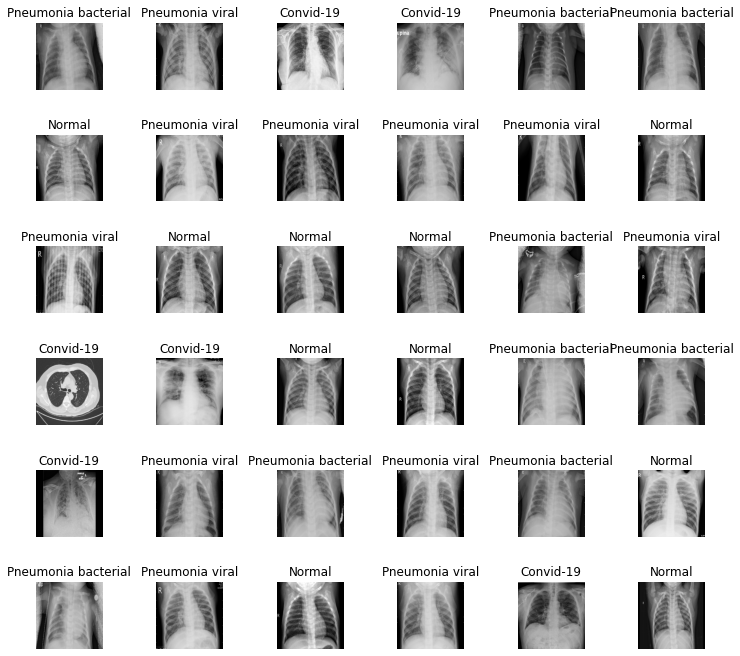

In [14]:
fig, axes = plt.subplots(6, 6, figsize=(12, 12))
axes = axes.ravel() #transforma matriz em vetor
for i in np.arange(0, 36):
  axes[i].imshow(train_images[i])
  axes[i].set_title(label_names[np.argmax(train_labels[i])])
  axes[i].axis('off')
plt.subplots_adjust(wspace=0.8)


# Carregamento da rede neural com pesos pré-treinados

In [15]:
base_model = ResNet50(weights='imagenet', include_top=False,
                      input_tensor = Input(shape=(256,256,3)))

94781440/94765736 [==============================] - 1s 0us/step


In [16]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [17]:
#visualizar a qtde de camadas
len(base_model.layers)

175

In [18]:
#congelar os pesos das camadas convulocionais
for layer in base_model.layers[:-10]: #[:-10] significa que as últimas camadas não serão retornadas no 'for', quer dizer que vai ficar com .trainable = True. Pois assim o algoritmo terá uma tendência a se adaptar melhor a essa caracteristica de imagens.
  layers.trainable = False #Caso fosse True a base de treinamento seria novamente treinada com os pesos dos zeros, e fazendo o treinamento novamente. Daí estariamos usando a arquitetura ResNet, sem o treinamento pré definido.

##Construção e trenamento do modelo de deep learning

In [19]:
#Revisar mais essa parte (Teoria)
head_model = base_model.output
head_model = AveragePooling2D()(head_model)
head_model = Flatten()(head_model)
head_model = Dense(256, activation = 'relu')(head_model)
head_model = Dropout(0.2)(head_model)
head_model = Dense(256, activation = 'relu')(head_model)
head_model = Dropout(0.2)(head_model)
head_model = Dense(4, activation = 'softmax')(head_model)

In [20]:
model = Model(inputs = base_model.input, outputs = head_model)

In [21]:
model.compile(loss = 'categorical_crossentropy', optimizer=optimizers.RMSprop(lr = 1e-4, decay=1e-6),
              metrics = ['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [22]:
#checkpointer = ModelCheckpoint(filepath='weights.hdf5', save_best_only=True) caso tivessemos uma base de dados de referencia 
checkpointer = ModelCheckpoint(filepath='weights.hdf5')

In [23]:
#Redefinindo a variavel train_generation de 40 imagens, para 4 imagens. 
train_generator = image_generator.flow_from_directory(batch_size= 4, directory=xray_directory,
                                                      shuffle = True, target_size=(256, 256), 
                                                      class_mode = 'categorical', subset='training')

Found 532 images belonging to 4 classes.


In [35]:
history = model.fit(train_generator, epochs= 25, callbacks=[checkpointer])

Epoch 1/25
133/133 [==============================] - 429s 3s/step - loss: 0.1656 - accuracy: 0.9680
Epoch 2/25
133/133 [==============================] - 426s 3s/step - loss: 0.2740 - accuracy: 0.9586
Epoch 3/25
133/133 [==============================] - 425s 3s/step - loss: 0.1614 - accuracy: 0.9718
Epoch 4/25
133/133 [==============================] - 427s 3s/step - loss: 0.0666 - accuracy: 0.9887
Epoch 5/25
133/133 [==============================] - 434s 3s/step - loss: 0.0993 - accuracy: 0.9831
Epoch 6/25
133/133 [==============================] - 433s 3s/step - loss: 0.0969 - accuracy: 0.9906
Epoch 7/25
133/133 [==============================] - 437s 3s/step - loss: 0.0420 - accuracy: 0.9962
Epoch 8/25
133/133 [==============================] - 432s 3s/step - loss: 0.0015 - accuracy: 1.0000
Epoch 9/25
133/133 [==============================] - 431s 3s/step - loss: 0.0248 - accuracy: 0.9962
Epoch 10/25
133/133 [==============================] - 432s 3s/step - loss: 0.0846 - accura

#Avaliação da rede neural

In [36]:
history.history.keys()

dict_keys(['loss', 'accuracy'])

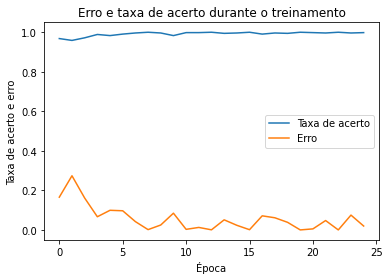

In [37]:
#Gráficos dos valores da base de dados de treinamento
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.title('Erro e taxa de acerto durante o treinamento')
plt.xlabel('Época')
plt.ylabel('Taxa de acerto e erro')
plt.legend(['Taxa de acerto', 'Erro']);

In [38]:
#Teste da base de dados de teste (outra base de dados)
test_directory = '/content/drive/MyDrive/Ciencias-de-Dados-para-Empresas/DepartamentoMedico/Test'

In [39]:
os.listdir(test_directory)

['3', '1', '2', '0']

In [40]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generation = test_gen.flow_from_directory(batch_size = 40, directory = test_directory,
                                               shuffle = True, target_size = (256,256),
                                               class_mode = 'categorical')

Found 40 images belonging to 4 classes.


In [41]:
#Avaliação da rede neural sera criada uma variavel do tensorflow
evaluate = model.evaluate(test_generation)

1/1 [==============================] - 13s 13s/step - loss: 5.2426 - accuracy: 0.7750


In [42]:
#[erro, acerto]
evaluate

[5.24263858795166, 0.7749999761581421]

In [43]:
#codificaçao p/ gerarmos as previsões e as respostas reais
prediction = []
original = []
image = []

for i in range(len(os.listdir(test_directory))):
  for item in os.listdir(os.path.join(test_directory, str(i))):
    #print(os.listdir(os.path.join(test_diretory, str(i))))
    img = cv2.imread(os.path.join(test_directory, str(i), item))
    img = cv2.resize(img, (256,256))
    image.append(img)
    img = img/255
    img = img.reshape(-1, 256, 256, 3)
    predict = model.predict(img)
    predict = np.argmax(predict)
    prediction.append(predict)
    original.append(i)

In [44]:
print(prediction)
len(prediction)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 3, 1, 0, 2, 1, 3, 3, 3, 3, 3, 1, 3, 3, 3, 1]


40

In [45]:
print(original)
len(original)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]


40

In [46]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [47]:
accuracy_score(original, prediction)

0.8

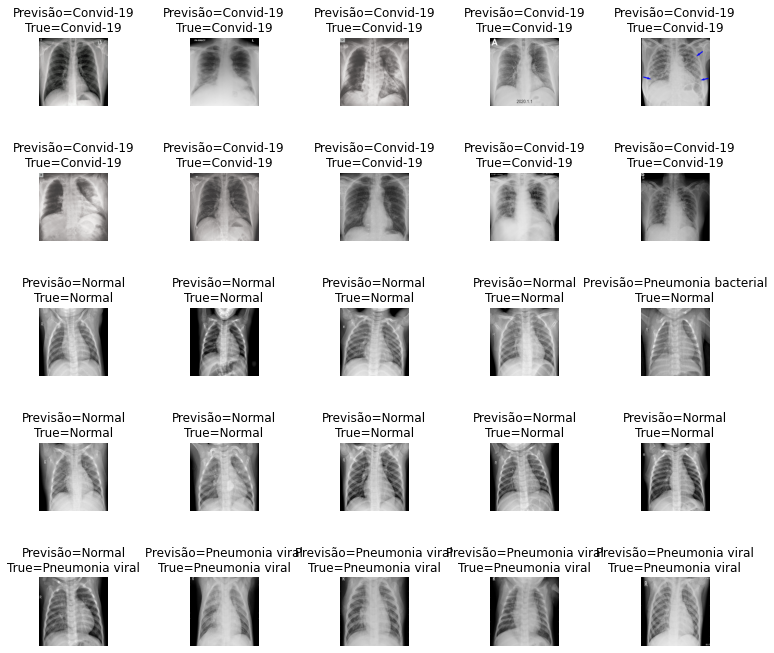

In [48]:
fig, axes = plt.subplots(5, 5, figsize=(12,12))
axes = axes.ravel()
for i in np.arange(0, 25):
  axes[i].imshow(image[i])
  axes[i].set_title('Previsão={}\nTrue={}'.format(str(label_names[prediction[i]]), str(label_names[original[i]])))
  axes[i].axis('off')
plt.subplots_adjust(wspace = 1.2)

In [49]:
label_names

{0: 'Convid-19', 1: 'Normal', 2: 'Pneumonia viral', 3: 'Pneumonia bacterial'}

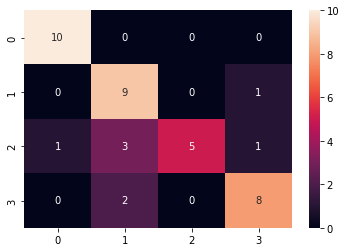

In [50]:
#matrix de confusão
cm = confusion_matrix(original, prediction)
sns.heatmap(cm, annot=True);

In [51]:
print(classification_report(original, prediction))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95        10
           1       0.64      0.90      0.75        10
           2       1.00      0.50      0.67        10
           3       0.80      0.80      0.80        10

    accuracy                           0.80        40
   macro avg       0.84      0.80      0.79        40
weighted avg       0.84      0.80      0.79        40



#Classificação de somente uma imagem

In [52]:
from keras.models import load_model
model_loaded = load_model('/content/weights.hdf5')

In [53]:
model_loaded.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [54]:
#carregando uma imagem
img = cv2.imread('/content/drive/MyDrive/Ciencias-de-Dados-para-Empresas/DepartamentoMedico/Test/0/radiol.2020200490.fig3.jpeg')

In [55]:
img, img.shape

(array([[[192, 192, 192],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [134, 134, 134]],
 
        [[192, 192, 192],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [134, 134, 134]],
 
        [[192, 192, 192],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [134, 134, 134]],
 
        ...,
 
        [[196, 196, 196],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  3,   3,   3],
         [134, 134, 134]],
 
        [[187, 187, 187],
         [  5,   5,   5],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  7,   7,   7],
         [129, 129, 129]],
 
        [[214, 214, 214],
         [ 80,  80,  80],
         [ 87,  87,  87],
         ...,
         [ 80,  80,  80],
  

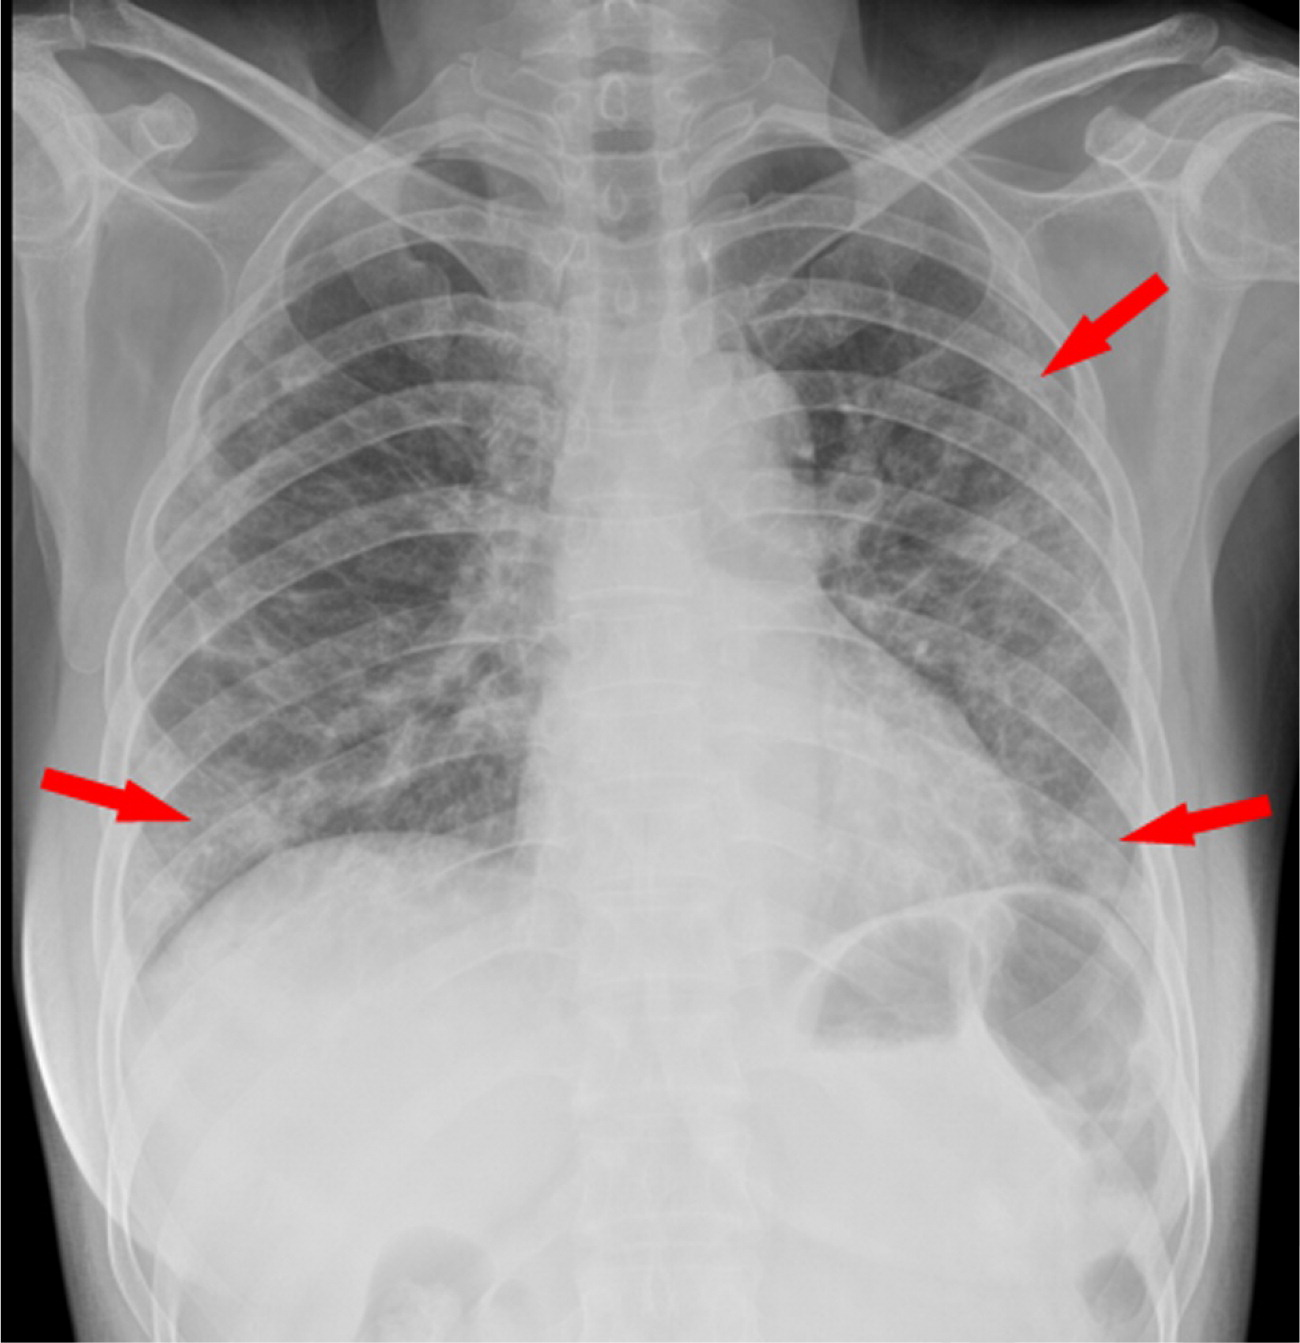

In [56]:
from google.colab.patches import cv2_imshow
cv2_imshow(img)

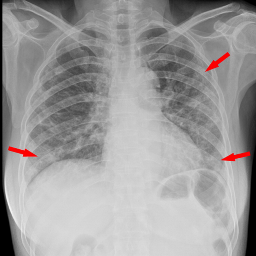

In [57]:
img = cv2.resize(img, (256, 256))
cv2_imshow(img)

In [58]:
#normalização
img = img / 255
img

array([[[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.10980392, 0.10980392, 0.10980392],
        ...,
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]],

       [[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.12941176, 0.12941176, 0.12941176],
        ...,
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]],

       [[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.16470588, 0.16470588, 0.16470588],
        ...,
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]],

       ...,

       [[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0

In [59]:
img.shape

(256, 256, 3)

In [60]:
img = img.reshape(-1, 256, 256, 3)
img.shape

(1, 256, 256, 3)

In [61]:
predict = model_loaded(img)
predict

<tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[1., 0., 0., 0.]], dtype=float32)>

In [62]:
predict2 = np.argmax(predict)
predict2

0

In [63]:
label_names[predict2], predict[0][predict2]

('Convid-19', <tf.Tensor: shape=(), dtype=float32, numpy=1.0>)